From https://github.com/krrish94/nerf-pytorch

# How to train your NeRF

An example notebook to demonstrate how to train a NeRF model on an example dataset. Unlike the [tiny nerf notebook](https://colab.research.google.com/drive/1rO8xo0TemN67d4mTpakrKrLp03b9bgCX), this uses the 3D coordinates _and the viewing directions_ as input, and _performs hierarchical sampling_ using the scheme suggested in the paper.

In [ ]:
import json
import math
import os

import cv2
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import torch

## Install dependencies

We use the [`torchsearchsorted`]() library for the `searchsorted()` module, used in hierarchical sampling.

In [ ]:
!pip install git+https://github.com/aliutkus/torchsearchsorted
import torchsearchsorted

#### Ensure GPU is enabled

It'll be very hard to train a NeRF otherwise.

In [ ]:
assert torch.cuda.is_available()
device = "cuda"
!nvidia-smi

## Helper functions

Basic helpers that help match tensorflow-equivalent functionality.


In [ ]:
def meshgrid_xy(tensor1: torch.Tensor, tensor2: torch.Tensor) -> (torch.Tensor, torch.Tensor):
    """Mimick np.meshgrid(..., indexing="xy") in pytorch. torch.meshgrid only allows "ij" indexing.
    (If you're unsure what this means, safely skip trying to understand this, and run a tiny example!)

    Args:
      tensor1 (torch.Tensor): Tensor whose elements define the first dimension of the returned meshgrid.
      tensor2 (torch.Tensor): Tensor whose elements define the second dimension of the returned meshgrid.
    """
    # TESTED
    ii, jj = torch.meshgrid(tensor1, tensor2)
    return ii.transpose(-1, -2), jj.transpose(-1, -2)


def cumprod_exclusive(tensor: torch.Tensor) -> torch.Tensor:
    r"""Mimick functionality of tf.math.cumprod(..., exclusive=True), as it isn't available in PyTorch.

    Args:
    tensor (torch.Tensor): Tensor whose cumprod (cumulative product, see `torch.cumprod`) along dim=-1
      is to be computed.

    Returns:
    cumprod (torch.Tensor): cumprod of Tensor along dim=-1, mimiciking the functionality of
      tf.math.cumprod(..., exclusive=True) (see `tf.math.cumprod` for details).
    """
    # TESTED
    # Only works for the last dimension (dim=-1)
    dim = -1
    # Compute regular cumprod first (this is equivalent to `tf.math.cumprod(..., exclusive=False)`).
    cumprod = torch.cumprod(tensor, dim)
    # "Roll" the elements along dimension 'dim' by 1 element.
    cumprod = torch.roll(cumprod, 1, dim)
    # Replace the first element by "1" as this is what tf.cumprod(..., exclusive=True) does.
    cumprod[..., 0] = 1.

    return cumprod

Ray functions (casting, normalizing, etc.)

In [ ]:
def get_ray_bundle(height: int, width: int, focal_length: float, tform_cam2world: torch.Tensor):
    r"""Compute the bundle of rays passing through all pixels of an image (one ray per pixel).

    Args:
    height (int): Height of an image (number of pixels).
    width (int): Width of an image (number of pixels).
    focal_length (float or torch.Tensor): Focal length (number of pixels, i.e., calibrated intrinsics).
    tform_cam2world (torch.Tensor): A 6-DoF rigid-body transform (shape: :math:`(4, 4)`) that
      transforms a 3D point from the camera frame to the "world" frame for the current example.

    Returns:
    ray_origins (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the centers of
      each ray. `ray_origins[i][j]` denotes the origin of the ray passing through pixel at
      row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
    ray_directions (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the
      direction of each ray (a unit vector). `ray_directions[i][j]` denotes the direction of the ray
      passing through the pixel at row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
    """
    # TESTED
    ii, jj = meshgrid_xy(
      torch.arange(width).to(tform_cam2world),
      torch.arange(height).to(tform_cam2world)
    )
    directions = torch.stack([(ii - width * .5) / focal_length,
                            -(jj - height * .5) / focal_length,
                            -torch.ones_like(ii)
                           ], dim=-1)
    ray_directions = torch.sum(directions[..., None, :] * tform_cam2world[:3, :3], dim=-1)
    ray_origins = tform_cam2world[:3, -1].expand(ray_directions.shape)
    return ray_origins, ray_directions


def ndc_rays(H, W, focal, near, rays_o, rays_d):
    # UNTESTED, but fairly sure.

    # Shift rays origins to near plane
    t = -(near + rays_o[..., 2]) / rays_d[..., 2]
    rays_o = rays_o + t[..., None] * rays_d

    # Projection
    o0 = -1. / (W / (2. * focal)) * rays_o[..., 0] / rays_o[..., 2]
    o1 = -1. / (H / (2. * focal)) * rays_o[..., 1] / rays_o[..., 2]
    o2 = 1. + 2. * near / rays_o[..., 2]

    d0 = -1. / (W / (2. * focal)) * (rays_d[..., 0] / rays_d[..., 2] - rays_o[..., 0] / rays_o[..., 2] )
    d1 = -1. / (H / (2. * focal)) * (rays_d[..., 1] / rays_d[..., 2] - rays_o[..., 1] / rays_o[..., 2] )
    d2 = -2. * near / rays_o[..., 2]

    rays_o = torch.stack([o0, o1, o2], -1)
    rays_d = torch.stack([d0, d1, d2], -1)

    return rays_o, rays_d

## Differentiable volume rendering

In [ ]:
def gather_cdf_util(cdf, inds):
    r"""A very contrived way of mimicking a version of the tf.gather()
    call used in the original impl.
    """
    orig_inds_shape = inds.shape
    inds_flat = [inds[i].view(-1) for i in range(inds.shape[0])]
    valid_mask = [torch.where(ind >= cdf.shape[1], torch.zeros_like(ind), torch.ones_like(ind)) for ind in inds_flat]
    inds_flat = [torch.where(ind >= cdf.shape[1], (cdf.shape[1] - 1) * torch.ones_like(ind), ind) for ind in inds_flat]
    cdf_flat = [cdf[i][ind] for i, ind in enumerate(inds_flat)]
    cdf_flat = [cdf_flat[i] * valid_mask[i] for i in range(len(cdf_flat))]
    cdf_flat = [cdf_chunk.reshape([1] + list(orig_inds_shape[1:])) for cdf_chunk in cdf_flat]
    return torch.cat(cdf_flat, dim=0)


def sample_pdf(bins, weights, num_samples, det=False):
    # TESTED (Carefully, line-to-line).
    # But chances of bugs persist; haven't integration-tested with
    # training routines.

    # Get pdf
    weights = weights + 1e-5  # prevent nans
    pdf = weights / weights.sum(-1).unsqueeze(-1)
    cdf = torch.cumsum(pdf, -1)
    cdf = torch.cat((torch.zeros_like(cdf[..., :1]), cdf), -1)

    # Take uniform samples
    if det:
        u = torch.linspace(0., 1., num_samples).to(weights)
        u = u.expand(list(cdf.shape[:-1]) + [num_samples])
    else:
        u = torch.rand(list(cdf.shape[:-1]) + [num_samples]).to(weights)

    # Invert CDF
    inds = torchsearchsorted.searchsorted(cdf.contiguous(), u.contiguous(), side='right')
    below = torch.max(torch.zeros_like(inds), inds-1)
    above = torch.min((cdf.shape[-1] - 1) * torch.ones_like(inds), inds)
    inds_g = torch.stack((below, above), -1)
    orig_inds_shape = inds_g.shape

    cdf_g = gather_cdf_util(cdf, inds_g)
    bins_g = gather_cdf_util(bins, inds_g)

    denom = cdf_g[..., 1] - cdf_g[..., 0]
    denom = torch.where(denom < 1e-5, torch.ones_like(denom), denom)
    t = (u - cdf_g[..., 0]) / denom
    samples = bins_g[..., 0] + t * (bins_g[..., 1] - bins_g[..., 0])

    return samples


def volume_render_radiance_field(radiance_field, depth_values,
                                 ray_directions,
                                 radiance_field_noise_std = 0.,
                                 white_background = False):
    # TESTED
    one_e_10 = torch.tensor([1e10], dtype=ray_directions.dtype,
                            device=ray_directions.device)
    dists = torch.cat((depth_values[..., 1:] - depth_values[..., :-1],
                       one_e_10.expand(depth_values[..., :1].shape)), dim=-1)
    dists = dists * ray_directions[..., None, :].norm(p=2, dim=-1)

    rgb = torch.sigmoid(radiance_field[..., :3])
    noise = 0.
    if radiance_field_noise_std > 0.:
        noise = torch.randn(radiance_field[..., 3].shape) * radiance_field_noise_std
        noise = noise.to(radiance_field)
    sigma_a = torch.nn.functional.relu(radiance_field[..., 3] + noise)
    alpha = 1. - torch.exp(-sigma_a * dists)
    weights = alpha * cumprod_exclusive(1. - alpha + 1e-10)

    rgb_map = weights[..., None] * rgb
    rgb_map = rgb_map.sum(dim=-2)
    depth_map = weights * depth_values
    depth_map = depth_map.sum(dim=-1)
    # depth_map = (weights * depth_values).sum(dim=-1)
    acc_map = weights.sum(dim=-1)
    disp_map = 1. / torch.max(
        1e-10 * torch.ones_like(depth_map), depth_map / acc_map
    )

    if white_background:
        rgb_map = rgb_map + (1. - acc_map[..., None])

    return rgb_map, disp_map, acc_map, weights, depth_map

## Train/Eval routines

Functions that implement the train/eval loop

In [ ]:
def get_minibatches(inputs: torch.Tensor, chunksize: int = 1024 * 8):
    r"""Takes a huge tensor (ray "bundle") and splits it into a list of minibatches.
    Each element of the list (except possibly the last) has dimension `0` of length
    `chunksize`.
    """
    return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]


def run_network(network_fn, pts, ray_batch, chunksize, embed_fn,
                embeddirs_fn):

    pts_flat = pts.reshape((-1, pts.shape[-1]))
    embedded = embed_fn(pts_flat)
    if embeddirs_fn is not None:
        viewdirs = ray_batch[..., None, -3:]
        input_dirs = viewdirs.expand(pts.shape)
        input_dirs_flat = input_dirs.reshape((-1, input_dirs.shape[-1]))
        embedded_dirs = embeddirs_fn(input_dirs_flat)
        embedded = torch.cat((embedded, embedded_dirs), dim=-1)

    batches = get_minibatches(embedded, chunksize=chunksize)
    preds = []
    for batch in batches:
        preds.append(network_fn(batch))
    radiance_field = torch.cat(preds, dim=0)
    radiance_field = radiance_field.reshape(list(pts.shape[:-1]) + [radiance_field.shape[-1]])
    return radiance_field


def positional_encoding(
    tensor, num_encoding_functions=6, include_input=True
) -> torch.Tensor:
    r"""Apply positional encoding to the input.

    Args:
    tensor (torch.Tensor): Input tensor to be positionally encoded.
    encoding_size (optional, int): Number of encoding functions used to compute
        a positional encoding (default: 6).
    include_input (optional, bool): Whether or not to include the input in the
        positional encoding (default: True)

    Returns:
    (torch.Tensor): Positional encoding of the input tensor.
    """
    # TESTED
    # Trivially, the input tensor is added to the positional encoding.
    encoding = [tensor] if include_input else []
    # Now, encode the input using a set of high-frequency functions and append the
    # resulting values to the encoding.
    for i in range(num_encoding_functions):
        for func in [torch.sin, torch.cos]:
          encoding.append(func(2. ** i * tensor))
    return torch.cat(encoding, dim=-1)


def img2mse(img_src, img_tgt):
    return torch.nn.functional.mse_loss(img_src, img_tgt)


def mse2psnr(mse):
    return -10. * math.log10(mse)

## NeRF forward pass

In [ ]:
def predict_and_render_radiance(
    ray_batch, model_coarse, model_fine, num_coarse, num_fine, chunksize,
    mode="train", lindisp=False, perturb=True,
    encode_position_fn=positional_encoding,
    encode_direction_fn=positional_encoding,
    radiance_field_noise_std=0.,
    white_background=False
):
    # TESTED
    num_rays = ray_batch.shape[0]
    ro, rd = ray_batch[..., :3], ray_batch[..., 3:6]
    bounds = ray_batch[..., 6:8].reshape((-1, 1, 2))
    near, far = bounds[..., 0], bounds[..., 1]

    t_vals = torch.linspace(0., 1., num_coarse).to(ro)
    if not lindisp:
        z_vals = near * (1. - t_vals) + far * t_vals
    else:
        z_vals = 1. / (1. / near * (1. - t_vals) + 1. / far * t_vals)
    z_vals = z_vals.expand([num_rays, num_coarse])

    if perturb:
        # Get intervals between samples.
        mids = 0.5 * (z_vals[..., 1:] + z_vals[..., :-1])
        upper = torch.cat((mids, z_vals[..., -1:]), dim=-1)
        lower = torch.cat((z_vals[..., :1], mids), dim=-1)
        # Stratified samples in those intervals.
        t_rand = torch.rand(z_vals.shape).to(ro)
        z_vals = lower + (upper - lower) * t_rand
    # pts -> (num_rays, N_samples, 3)
    pts = ro[..., None, :] + rd[..., None, :] * z_vals[..., :, None]


    radiance_field = run_network(model_coarse,
                                 pts,
                                 ray_batch,
                                 chunksize,
                                 encode_position_fn,
                                 encode_direction_fn,
                                )
    
    rgb_coarse, disp_coarse, acc_coarse, weights, depth_coarse = volume_render_radiance_field(
        radiance_field, z_vals, rd,
        radiance_field_noise_std=radiance_field_noise_std,
        white_background=white_background
    )

    rgb_fine, disp_fine, acc_fine = None, None, None
    if num_fine > 0:
        # rgb_map_0, disp_map_0, acc_map_0 = rgb_map, disp_map, acc_map

        z_vals_mid = .5 * (z_vals[..., 1:] + z_vals[..., :-1])
        z_samples = sample_pdf(
            z_vals_mid, weights[..., 1:-1], num_fine,
            det=(perturb == 0.)
        )
        z_samples = z_samples.detach()

        z_vals, _ = torch.sort(torch.cat((z_vals, z_samples), dim=-1), dim=-1)
        # pts -> (N_rays, N_samples + N_importance, 3)
        pts = ro[..., None, :] + rd[..., None, :] * z_vals[..., :, None]

        radiance_field = run_network(model_fine,
                                     pts,
                                     ray_batch,
                                     chunksize,
                                     encode_position_fn,
                                     encode_direction_fn
                                    )
        rgb_fine, disp_fine, acc_fine, _, _ = volume_render_radiance_field(
            radiance_field, z_vals, rd,
            radiance_field_noise_std=radiance_field_noise_std,
            white_background=white_background
        )

    return rgb_coarse, disp_coarse, acc_coarse, rgb_fine, disp_fine, acc_fine


def nerf_forward_pass(
    H, W, focal, model_coarse, model_fine, batch_rays,
    use_viewdirs, near, far, chunksize, num_coarse, num_fine, mode="train",
    lindisp=False, perturb=True, encode_position_fn=positional_encoding,
    encode_direction_fn=positional_encoding, radiance_field_noise_std=0.,
    white_background=False
):
    ray_origins = batch_rays[0]
    ray_directions = batch_rays[1]
    if use_viewdirs:
        # Provide ray directions as input
        viewdirs = ray_directions
        viewdirs = viewdirs / viewdirs.norm(p=2, dim=-1).unsqueeze(-1)
        viewdirs = viewdirs.reshape((-1, 3))
    ray_shapes = ray_directions.shape  # Cache now, to restore later.
    ro, rd = ndc_rays(H, W, focal, 1., ray_origins, ray_directions)
    ro = ro.reshape((-1, 3))
    rd = rd.reshape((-1, 3))
    near = near * torch.ones_like(rd[..., :1])
    far = far * torch.ones_like(rd[..., :1])
    rays = torch.cat((ro, rd, near, far), dim=-1)
    if use_viewdirs:
        rays = torch.cat((rays, viewdirs), dim=-1)

    batches = get_minibatches(rays, chunksize=chunksize)
    # concat everything in the end.
    rgb_coarse, disp_coarse, acc_coarse = [], [], []
    rgb_fine, disp_fine, acc_fine = None, None, None
    for batch in batches:
        rc, dc, ac, rf, df, af = predict_and_render_radiance(
            batch, model_coarse, model_fine, num_coarse, num_fine, chunksize,
            mode, lindisp=lindisp, perturb=perturb,
            encode_position_fn=encode_position_fn,
            encode_direction_fn=encode_direction_fn,
            radiance_field_noise_std=radiance_field_noise_std,
            white_background=white_background
        )
        rgb_coarse.append(rc)
        disp_coarse.append(dc)
        acc_coarse.append(ac)
        if rf is not None:
            if rgb_fine is None:
                rgb_fine = [rf]
            else:
                rgb_fine.append(rf)
        if df is not None:
            if disp_fine is None:
                disp_fine = [df]
            else:
                disp_fine.append(df)
        if af is not None:
            if acc_fine is None:
                acc_fine = [af]
            else:
                acc_fine.append(af)

    rgb_coarse_ = torch.cat(rgb_coarse, dim=0)
    disp_coarse_ = torch.cat(disp_coarse, dim=0)
    acc_coarse_ = torch.cat(acc_coarse, dim=0)
    if rgb_fine is not None:
        rgb_fine_ = torch.cat(rgb_fine, dim=0)
    else:
        rgb_fine_ = None
    if disp_fine is not None:
        disp_fine_ = torch.cat(disp_fine, dim=0)
    else:
        disp_fine_ = None
    if acc_fine is not None:
        acc_fine_ = torch.cat(acc_fine, dim=0)
    else:
        acc_fine_ = None

    return rgb_coarse_, disp_coarse_, acc_coarse_, rgb_fine_, disp_fine_, acc_fine_

## Load dataset

For convenience, we only show a low-res example in this notebook

In [ ]:
# Download and extract data
!mkdir data
!wget -P data https://people.eecs.berkeley.edu/~bmild/nerf/nerf_example_data.zip
!unzip data/nerf_example_data.zip -d data

Utils to load NeRF data into PyTorch

In [ ]:
def translate_by_t_along_z(t):
    tform = np.eye(4).astype(np.float32)
    tform[2][3] = t
    return tform


def rotate_by_phi_along_x(phi):
    tform = np.eye(4).astype(np.float32)
    tform[1, 1] = tform[2, 2] = np.cos(phi)
    tform[1, 2] = -np.sin(phi)
    tform[2, 1] = -tform[1, 2]
    return tform


def rotate_by_theta_along_y(theta):
    tform = np.eye(4).astype(np.float32)
    tform[0, 0] = tform[2, 2] = np.cos(theta)
    tform[0, 2] = -np.sin(theta)
    tform[2, 0] = -tform[0, 2]
    return tform


def pose_spherical(theta, phi, radius):
    c2w = translate_by_t_along_z(radius)
    c2w = rotate_by_phi_along_x(phi / 180. * np.pi) @ c2w
    c2w = rotate_by_theta_along_y(theta / 180 * np.pi) @ c2w
    c2w = np.array([
        [-1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1]
    ]) @ c2w
    return c2w


def load_blender_data(basedir, downscaleFactor=8, testskip=1):
    splits = ["train", "val", "test"]
    metas = {}
    for s in splits:
        with open(os.path.join(basedir, f"transforms_{s}.json"), "r") as fp:
            metas[s] = json.load(fp)

    all_imgs = []
    all_poses = []
    counts = [0]
    for s in splits:
        meta = metas[s]
        imgs = []
        poses = []
        if s == "train" or testskip == 0:
            skip = 1
        else:
            skip = testskip

        for frame in meta["frames"][::skip]:
            fname = os.path.join(basedir, frame["file_path"] + ".png")
            imgs.append(imageio.imread(fname))
            poses.append(np.array(frame["transform_matrix"]))
        imgs = (np.array(imgs) / 255.).astype(np.float32)
        poses = np.array(poses).astype(np.float32)
        counts.append(counts[-1] + imgs.shape[0])
        all_imgs.append(imgs)
        all_poses.append(poses)

    i_split = [np.arange(counts[i], counts[i + 1]) for i in range(3)]

    imgs = np.concatenate(all_imgs, 0)
    poses = np.concatenate(all_poses, 0)

    H, W = imgs[0].shape[:2]
    camera_angle_x = float(meta["camera_angle_x"])
    focal = .5 * W / np.tan(.5 * camera_angle_x)

    render_poses = torch.stack([
        torch.from_numpy(
            pose_spherical(angle, -30., 4.)
        ) for angle in np.linspace(-180, 180, 40 + 1)[:-1]
    ], 0)

    # Apply scale factor
    targetsize = imgs.shape[1] // downscaleFactor
    H = H // downscaleFactor
    W = W // downscaleFactor
    focal = focal / downscaleFactor
    imgs = [torch.from_numpy(
        cv2.resize(imgs[i], dsize=(targetsize, targetsize), interpolation=cv2.INTER_AREA)
    ) for i in range(imgs.shape[0])]
    imgs = torch.stack(imgs, 0)

    poses = torch.from_numpy(poses)

    return imgs, poses, render_poses, [H, W, focal], i_split

In [ ]:
# Load data
images, poses, render_poses, hwf, i_split = load_blender_data(
    "data/nerf_synthetic/lego",
    downscaleFactor=16,
    testskip=1
)
near = 0.
far = 1.

i_train, i_val, i_test = i_split
H, W, focal = hwf
H, W = int(H), int(W)
hwf = [H, W, focal]

Visualize a few samples

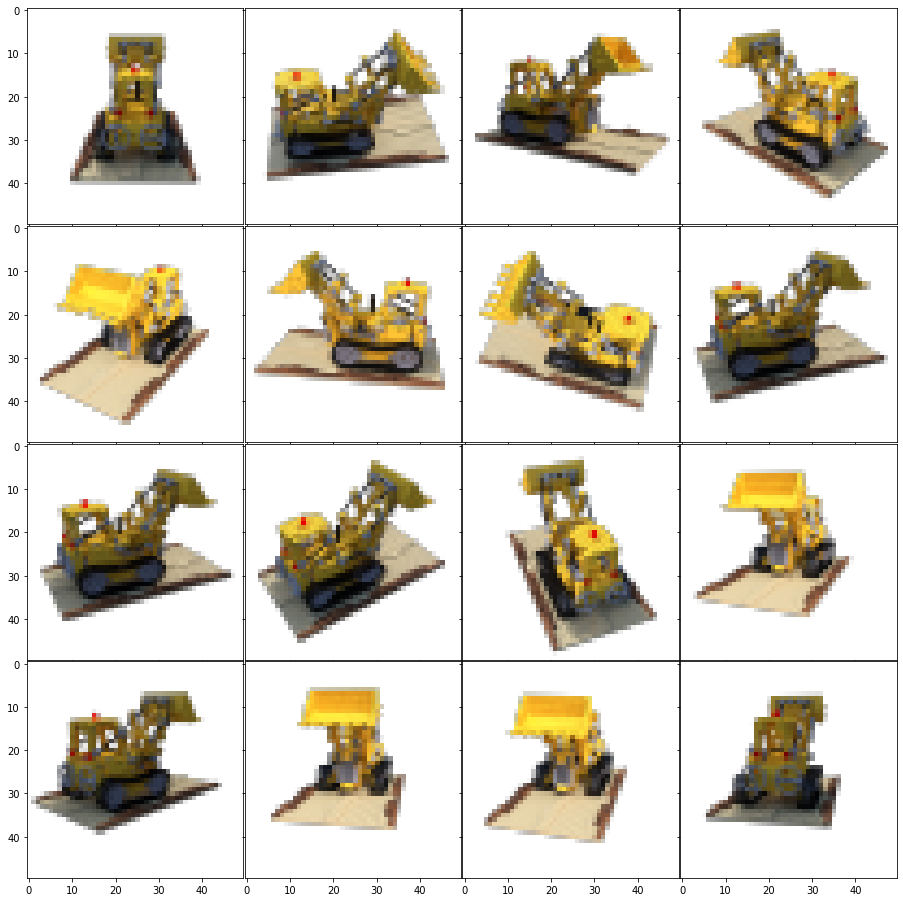

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(16, 16))
imagegrid = ImageGrid(fig, 111, nrows_ncols=(4, 4))
imagesamples = [images[i] for i in range(0, 80, 5)]
for ax, im in zip(imagegrid, imagesamples):
    ax.imshow(im)

## Define the NeRF model

In [ ]:
class VeryTinyNeRFModel(torch.nn.Module):
    r"""Define a "very tiny" NeRF model comprising three fully connected layers.
    """

    def __init__(
        self, filter_size=128, num_encoding_fn_xyz=6, num_encoding_fn_dir=4,
        use_viewdirs=True, include_input_xyz=True, include_input_dir=True
    ):
        super(VeryTinyNeRFModel, self).__init__()

        self.include_input_xyz = 3 if include_input_xyz else 0
        self.include_input_dir = 3 if include_input_dir else 0
        self.dim_xyz = self.include_input_xyz + 2 * 3 * num_encoding_fn_xyz
        self.dim_dir = self.include_input_dir + 2 * 3 * num_encoding_fn_dir
        if not use_viewdirs:
          self.dim_dir = 0

        # Input layer (default: 65 -> 128)
        self.layer1 = torch.nn.Linear(self.dim_xyz + self.dim_dir, filter_size)
        # Layer 2 (default: 128 -> 128)
        self.layer2 = torch.nn.Linear(filter_size, filter_size)
        # Layer 3 (default: 128 -> 4)
        self.layer3 = torch.nn.Linear(filter_size, 4)
        # Short hand for torch.nn.functional.relu
        self.relu = torch.nn.functional.relu

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x


class ReplicateNeRFModel(torch.nn.Module):
    r"""NeRF model that (almost) follows the figure (from the supp. material of 
    the NeRF paper), but has about half the number of layers.
    """

    def __init__(
        self, hidden_size=128, num_encoding_fn_xyz=6, num_encoding_fn_dir=4,
        include_input_xyz=True, include_input_dir=True
    ):
        super(ReplicateNeRFModel, self).__init__()
        
        self.include_input_xyz = 3 if include_input_xyz else 0
        self.include_input_dir = 3 if include_input_dir else 0
        self.dim_xyz = self.include_input_xyz + 2 * 3 * num_encoding_fn_xyz
        self.dim_dir = self.include_input_dir + 2 * 3 * num_encoding_fn_dir

        self.layer1 = torch.nn.Linear(self.dim_xyz, hidden_size)
        self.layer2 = torch.nn.Linear(hidden_size, hidden_size)
        self.layer3 = torch.nn.Linear(hidden_size, 1 + hidden_size)
        self.layer4 = torch.nn.Linear(hidden_size + self.dim_dir, hidden_size // 2)
        self.layer5 = torch.nn.Linear(hidden_size // 2, hidden_size // 2)
        self.layer6 = torch.nn.Linear(hidden_size // 2, 3)
        self.relu = torch.nn.functional.relu
    
    def forward(self, x):
        xyz = x[..., :self.dim_xyz]
        direction = x[..., self.dim_xyz:]
        x_ = self.relu(self.layer1(xyz))
        x_ = self.relu(self.layer2(x_))
        sigma_feat = self.layer3(x_)
        sigma = sigma_feat[..., 0].unsqueeze(-1)
        feat = sigma_feat[..., 1:]
        y_ = self.relu(self.layer4(torch.cat((feat, direction), dim=-1)))
        y_ = self.relu(self.layer5(y_))
        y_ = self.layer6(y_)
        return torch.cat((y_, sigma), dim=-1)

## Run training / validation

This should take a WHILE (3-4 hours or more) to converge. But, you should be able to see training progress soon enough (in the first 1000 iterations).

In [ ]:
from tqdm.auto import trange, tqdm

In [ ]:
!pip install wandb
import wandb
wandb.login()

In [ ]:
# seed = 1234
seed = 2350
np.random.seed(seed)
torch.manual_seed(seed)

######################################
# CONFIGURE EXPERIMENT PARAMETERS
######################################
# Whether to use the fine-level model
use_fine_model = False
# Whether to use viewing directions as additional inputs
use_viewdirs = True
# Number of rays to sample per minibatch
num_random_rays = 512
# Number of coarse depths to sample
num_coarse = 32
# Number of fine depths to sample
num_fine = 32
if not use_fine_model:
    num_fine = 0
# Chunksize (minibatch to pass to the neural net at one time)
chunksize = 4096
# Whether to include the position (xyz) itself in its positional encoding
include_input_xyz = False
# Number of encoding functions to use for positional encoding of the coordinates
num_encoding_fn_xyz = 6
# Whether to include the direction itself in its positional encoding
include_input_dir = False
# Number of encoding functions to use for positional encoding of the direction
num_encoding_fn_dir = 6
# Function used to encode position
encode_position_fn = lambda x: positional_encoding(
    x, num_encoding_functions=num_encoding_fn_xyz, include_input=include_input_xyz
)
# Function used to encode direction
encode_direction_fn = lambda x: positional_encoding(
    x, num_encoding_functions=num_encoding_fn_dir, include_input=include_input_dir
)
# Number of iterations to run optimization for
num_iters = 100000
# Number of iterations after which to validate once
validate_every = 50
# Number of iterations after which to save model
save_every = 1000
# Learning rate for optimizer
learning_rate = 5e-3
######################################
model_coarse = VeryTinyNeRFModel(
    filter_size=128, 
    num_encoding_fn_xyz=num_encoding_fn_xyz, 
    num_encoding_fn_dir=num_encoding_fn_dir,
    use_viewdirs=True, 
    include_input_xyz=include_input_xyz, 
    include_input_dir=include_input_dir
)
model_coarse.to(device)
if use_fine_model:
    model_fine = VeryTinyNeRFModel(
        filter_size=128, 
        num_encoding_fn_xyz=num_encoding_fn_xyz, 
        num_encoding_fn_dir=num_encoding_fn_dir,
        use_viewdirs=True, 
        include_input_xyz=include_input_xyz, 
        include_input_dir=include_input_dir
    )
    model_fine.to(device)
else:
    model_fine = None

# Initialize optimizer
if use_fine_model:
    optimizer = torch.optim.Adam(
        list(model_coarse.parameters()) + list(model_fine.parameters()),
        lr=learning_rate
    )
else:
    optimizer = torch.optim.Adam(model_coarse.parameters(), lr=learning_rate)
    
i = 0

train_losses = []
train_iternums = []
val_losses = []
val_iternums = []

# Train/Eval loop
wandb.init(name='full_nerf', project='NeRF')
for i in trange(i, num_iters):

    if i == 64000:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 5e-3
        print("Updated learning rate!")

    # Train
    img_idx = np.random.choice(i_train)
    img_target = images[img_idx].to(device)
    pose_target = poses[img_idx, :3, :4].to(device)
    ray_origins, ray_directions = get_ray_bundle(H, W, focal, pose_target)
    coords = torch.stack(meshgrid_xy(torch.arange(H).to(device),
                                      torch.arange(W).to(device)), dim=-1)
    coords = coords.reshape((-1, 2))
    batch_rays = torch.stack([ray_origins, ray_directions], dim=0)
    target_ray_values = img_target.reshape((-1, 4))
    
    rgb_coarse, _, _, rgb_fine, _, _ = nerf_forward_pass(
        H, W, focal, model_coarse, model_fine, batch_rays, use_viewdirs=use_viewdirs,
        near=near, far=far, chunksize=chunksize, num_coarse=num_coarse,
        num_fine=num_fine, mode="train", lindisp=False, perturb=True,
        encode_position_fn=encode_position_fn,
        encode_direction_fn=encode_direction_fn
    )

    coarse_loss = img2mse(rgb_coarse[..., :3], target_ray_values[..., :3])
    if use_fine_model:
        fine_loss = img2mse(rgb_fine[..., :3], target_ray_values[..., :3])
        loss = coarse_loss + fine_loss
    else:
        loss = coarse_loss
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    train_losses.append(loss.item())
    train_iternums.append(i)


    # Validate
    if i % validate_every == 0:
        print("Train loss:", loss.item(), "Train PSNR:", mse2psnr(loss.item()))
        img_idx = np.random.choice(i_val)
        img_target = images[img_idx].to(device)
        pose_target = poses[img_idx, :3, :4].to(device)
        ray_origins, ray_directions = get_ray_bundle(H, W, focal, pose_target)
        original_shape = ray_origins.shape
        batch_rays = torch.stack([ray_origins, ray_directions], dim=0)
        rgb_coarse, _, _, rgb_fine, _, _ = nerf_forward_pass(
            H, W, focal, model_coarse, model_fine, batch_rays, use_viewdirs=use_viewdirs,
            near=near, far=far, chunksize=chunksize, num_coarse=num_coarse,
            num_fine=num_fine, mode="validation", lindisp=False, perturb=False,
            encode_position_fn=encode_position_fn, encode_direction_fn=encode_direction_fn
        )
        rgb_coarse = rgb_coarse.reshape(original_shape)
        if use_fine_model:
            rgb_fine = rgb_fine.reshape(original_shape)
        coarse_loss = img2mse(rgb_coarse[..., :3], img_target[..., :3])
        if use_fine_model:
            fine_loss = img2mse(rgb_fine[..., :3], img_target[..., :3])
            val_loss = coarse_loss + fine_loss
        else:
            val_loss = coarse_loss
        print("Val loss:", val_loss.item(), "Val PSNR:", mse2psnr(val_loss.item()))
        val_losses.append(val_loss.item())
        val_iternums.append(i)

        if use_fine_model:
            plt.figure(figsize=(10, 4))
            plt.subplot(131)
            plt.imshow(img_target[..., :3].detach().cpu().numpy())
            plt.title(f"Iteration {i}: Ground-truth image")
            plt.subplot(132)
            plt.imshow(rgb_coarse[..., :3].detach().cpu().numpy())
            plt.title("Coarse image")
            plt.subplot(133)
            plt.imshow(rgb_fine[..., :3].detach().cpu().numpy())
            plt.title("Fine image")
            plt.show()
        else:
            plt.figure(figsize=(8, 4))
            plt.subplot(121)
            plt.imshow(img_target[..., :3].detach().cpu().numpy())
            plt.title(f"Iteration {i}: Ground-truth image")
            plt.subplot(122)
            plt.imshow(rgb_coarse[..., :3].detach().cpu().numpy())
            plt.title("Coarse image")
            plt.show()
        
        if use_fine_model:
            wandb.log({
                'ground truth': wandb.Image(img_target[..., :3].detach().cpu().numpy()),
                'coarse image': wandb.Image(rgb_coarse[..., :3].detach().cpu().numpy()),
                'fine image': wandb.Image(rgb_fine[..., :3].detach().cpu().numpy()),
                'train loss': loss.item(),
                'train PSNR': mse2psnr(loss.item()),
                'val loss': val_loss.item(),
                'val PSNR': mse2psnr(val_loss.item()),
                'step': i
            })
        else:
            wandb.log({
                'ground truth': wandb.Image(img_target[..., :3].detach().cpu().numpy()),
                'coarse image': wandb.Image(rgb_coarse[..., :3].detach().cpu().numpy()),
                'train loss': loss.item(),
                'train PSNR': mse2psnr(loss.item()),
                'val loss': val_loss.item(),
                'val PSNR': mse2psnr(val_loss.item()),
                'step': i
            })